# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011)
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

## 1. Implementing the PEGASOS SVM
We will implement the simplest SVM implementation. 
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:
![alt text](https://snag.gy/Gpi1Mk.jpg)

Here is a little more deailed explanation (it's recommended to read the full paper).
![alt_text](https://snag.gy/koA0ue.jpg)

1. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.
  * decision function is simply the Euclidean distance (with a sign that designates from which side of the decision plane the point is located) from the decision plane to each sample. So, if you query for some point, you will get a positive number if the point is above the plain and negative if it is below it. The value will give you the distance which you can use for a scoring, for example, after you normalize it. If a point is very near to the decision plane it will have a lower score than a point that is farther. Also, if your point is located inside the margins of the model, you may want to treat the score as a probability for assigning the point to one class or another.

2. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

3. Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 
  * you can use scikit-learn's `validation_curve`

4. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

5. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below

![](https://i.ibb.co/0BGwVz7/1.png)

###1.1 Implementation of the class PegasosSVM
The class has parameter  λ  (lambda_param) and T (n_iters) and methods fit and predict and decision_function

In [ ]:
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt

In [ ]:
class PegasosSVM:
    def __init__(self, lambda_param=1, n_iters=1000, verbose = False, track_loss = False):
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.verbose = verbose
        self.track_loss = track_loss
        self.loss_history = None
        self.acc_history = None
    
    def fit(self, X, y):
        """ Fitting the model using the PEGASOS algorithm"""

        # Saving the original variables
        X0 = X
        y0 = y

        # Padding and updating labels
        X_pad = self.pad(X)
        y = self.update_labels(y)

        # Initializing weights
        self.w = np.zeros(X_pad.shape[1]) 

        # Number of samples
        num_sample = X_pad.shape[0]

        if self.track_loss:
            self.loss_history = []
            self.acc_history = []

        # Running T iterations
        for t in range(1, self.n_iters + 1):  # Starting at 1 to avoid devision in 0
            # Selecting a random samlpe
            i = np.random.randint(num_sample)
            
            # Current learning rate (getting slower by iterations)
            lr = 1 / (self.lambda_param * t)

            loss = self.decision_function(X_pad[i], y[i])
            if self.track_loss:
                self.loss_history.append(loss)
                self.acc_history.append(self.score(X, y0))
            if loss < 1: # If prediction correct
                self.w = (1 - lr * self.lambda_param)*self.w + (lr * y[i] * X_pad[i])
            else:
                self.w = (1 - lr * self.lambda_param)*self.w
            
            # Screen printing
            if self.verbose and (t % 10) == 1:
                print(f'Iteration {t} \tloss: {loss} \taccuracy: {self.score(X, y0)}')
        if self.verbose:
            print(f'Final iteration: {t} \tloss: {loss} \taccuracy:  {self.score(X, y0)}')
    
    def predict(self, X):
        """ Predicts based on the weights """
        X = self.pad(X) # Padding
        dist = np.dot(X, self.w)
        pred_y = np.ones(X.shape[0], dtype=int)  # An array of 1s
        pred_y[dist <= 0] = 0  # replace negative distances with zeros
        return pred_y
    
    @staticmethod
    def pad(X):
        """ Adds a column of 1s """
        X = np.c_[X, np.ones(X.shape[0])]
        return X
    
    @staticmethod
    def update_labels(y):
        """ replace 0 with -1 if needed """
        y = y.copy()
        y[y < 1] = -1
        return y
    
    def decision_function(self, Xi, yi):  # TODO: euclidean distance??
        """ Predicts and returns the distance from the plane """
        y_pred = np.dot(self.w, Xi) 
        loss = (yi * y_pred)
        return loss

    def score(self, X, y):
        """ Scores the fitting using MSE """
        pred_y = self.predict(X)
        accuracy = np.ones(y.shape[0])
        accuracy[pred_y != y] = 0  # Replace in 0 all the false predictions
        accuracy = np.mean(accuracy)
        return accuracy
    
    def get_params(self, deep=False):
        """ For the validation_curve function """
        param_dic = {
            'lambda_param': 1.0,
            'n_iters': 1000,
            'verbose': False,
            'track_loss': False}
        return param_dic
    
    def set_params(self, **parameters):
      for parameter, value in parameters.items():
          setattr(self, parameter, value)
      return self


In [ ]:
# Uploading data
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)
print(f'The database includes {X.shape[0]} and {X.shape[1]} features')

#data = load_breast_cancer()
#print(data['DESCR'])

The database includes 569 and 30 features


In [ ]:
# Testing the model once
clf = make_pipeline(StandardScaler(), PegasosSVM(n_iters = 100, lambda_param=1, verbose = True))
clf.fit(X, y)


Iteration 1 	loss: 0.0 	accuracy: 0.9086115992970123
Iteration 11 	loss: 1.7505122162260351 	accuracy: 0.9086115992970123
Iteration 21 	loss: 1.8797639909493236 	accuracy: 0.8910369068541301
Iteration 31 	loss: 1.9607797205997173 	accuracy: 0.9050966608084359
Iteration 41 	loss: -0.3045007830808912 	accuracy: 0.9191564147627417
Iteration 51 	loss: 0.37004146402033966 	accuracy: 0.9226713532513181
Iteration 61 	loss: 1.2033198061777364 	accuracy: 0.9226713532513181
Iteration 71 	loss: 1.4295445192619272 	accuracy: 0.9525483304042179
Iteration 81 	loss: 1.8612904756116595 	accuracy: 0.9420035149384886
Iteration 91 	loss: 0.8008038511486022 	accuracy: 0.945518453427065
Final iteration: 100 	loss: 1.912348152530647 	accuracy:  0.9384885764499121


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pegasossvm', <__main__.PegasosSVM object at 0x7f0b7d69ca30>)])

###1.2 Testing our class on the breast cancer database load_breast_cancer, and comparing our results to the Native Scikit-learn implementation LinearSVC

In [ ]:
# Using cross validation to compare our model to the native Scikit-learn implementation

from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

home_clf = make_pipeline(StandardScaler(), PegasosSVM(n_iters = 1000, lambda_param=0.1, verbose = False))
sk_clf = make_pipeline(StandardScaler(), LinearSVC())

print('Mean score of PEGASOS SVM:\t',np.mean(cross_val_score(home_clf, X, y, cv=10)))
print('Mean score of sklearn SMV:\t', np.mean(cross_val_score(sk_clf, X, y, cv=10)));


Mean score of PEGASOS SVM:	 0.963095238095238
Mean score of sklearn SMV:	 0.9718984962406015


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


###1.3 Analysis of the effect of the hyper parameter  λ  on the training and test error.

In [ ]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(classifier, X, y, param_grid, log = False):

    # Enlarging font and figure size
    if len(param_grid) > 1:
        plt.rcParams["figure.figsize"] = (13, 5)
    else:
        plt.rcParams["figure.figsize"] = (8, 6)
    plt.rcParams.update({'font.size': 14})

    i = 1
    for param_name, param_range in param_grid.items():

        # Defining the parameters
        train_scores, test_scores = validation_curve(classifier, X, y, param_name=param_name, 
                                                      param_range=param_range, cv=10)

        dic = {'Train scores': train_scores, 'Test scores': test_scores}

        plt.subplot(1, len(param_grid), i)  # Plotting subplots for the 4th part

        for name, score in dic.items():
            scores_mean = score.mean(axis=1)
            scores_std = score.std(axis=1)

            # Plottig the mean
            plt.plot(param_range, scores_mean, label=name)

            # Filling the area
            plt.fill_between(param_range, (scores_mean - scores_std), (scores_mean + scores_std), alpha=0.2)

        plt.title(f'Validation Curve for {param_name}')
        plt.ylabel('Score')
        plt.legend()

        if log or param_name == 'C':
            plt.xscale("log")
            plt.xlabel(f'{param_name} (log)')
        else:
            plt.xlabel(param_name)
        
        i += 1 # For the plotting
        
plt.show;

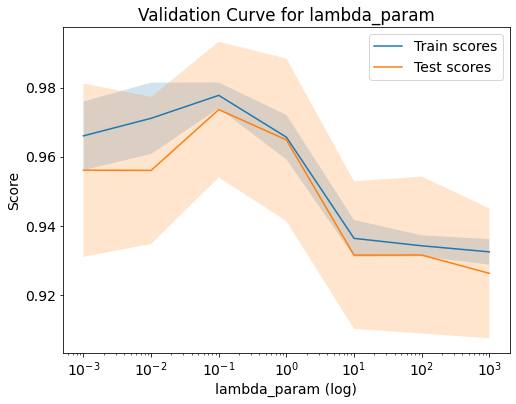

In [ ]:
# Standaring X
scaler = StandardScaler()
scaler.fit(X)
norm_X = scaler.transform(X)

plot_validation_curve(PegasosSVM(), norm_X, y, {'lambda_param': np.logspace(-3, 3, 7)}, log=True)

We can see that the optimal $λ$ is around 0.1.

###1.4 Analysis of the learning curve (performance as function of training size)

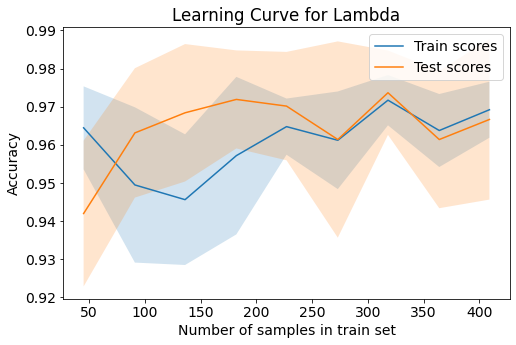

In [ ]:
from sklearn.model_selection import learning_curve

# Enlarging font and figure size
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams.update({'font.size': 14})

# Enlarging font size
plt.rcParams.update({'font.size': 14})

# Definig a pipeline of normalizing and fitting
clf = make_pipeline(StandardScaler(), PegasosSVM(n_iters = 1000, lambda_param=1))

train_prop = np.arange(0.1, 1, 0.1)  # [0.1, 0.2, 0.3 .... 0.9]
train_sizes, train_scores, test_scores, _, _ = learning_curve(clf, X, y, cv=5, return_times=True, train_sizes=train_prop)

dic = {'Train scores': train_scores, 'Test scores': test_scores}

for name, score in dic.items():
    scores_mean = score.mean(axis=1)
    scores_std = score.std(axis=1)

    # Plottig the mean
    plt.plot(train_sizes, scores_mean, label=name)

    # Filling the area
    plt.fill_between(train_sizes, (scores_mean - scores_std), (scores_mean + scores_std), alpha=0.2)

plt.title('Learning Curve for Lambda')
plt.xlabel('Number of samples in train set')
plt.ylabel('Accuracy')
plt.legend()

plt.show;


We can see that from some point, the learning does not improve with the training size.

## 2. The importance of class weighting in SVM
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this we created for you a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and 
$$
p(y=0) = 0.1
$$. 

TODO:
1. For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

2. Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

3. repeat the experiment but now set the `class_weight` to be `balanced`. 
The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

Explain what was the problem and how changing class weight solved it.


## Answer 

In [ ]:
# a function make_data which generates a two dimensional dataset with n_samples=1000 where a fraction imbalance=0.1 is
# labeled 0 and the rest 1. The distribution of  𝑥  given  𝑦=0  or  𝑦=1  is gaussian with std 0.5 or 2, respectively and that
# the centers are at  𝑥1=0  and  𝑥2=−𝑑/2  and  𝑥2=𝑑/2 ,

def make_data(d, imbalance=0.1):
    n_samples=1000
    X = np.zeros((n_samples, 2))
    y = np.random.binomial(1, 1-imbalance, n_samples)
    size_0 = np.sum(y==0)
    size_1 = np.sum(y==1)
    X[y==0,0] = np.random.normal(loc=0, scale=0.5, size=size_0)
    X[y==1,0] = np.random.normal(loc=0, scale=2, size=size_1)
    X[y==0,1] = np.random.normal(loc=-d/2, scale=0.5, size=size_0)
    X[y==1,1] = np.random.normal(loc=d/2, scale=2, size=size_1)
    return X, y

### 2.1 Plotting a scatter plot of the data for d=10 and d=2. 

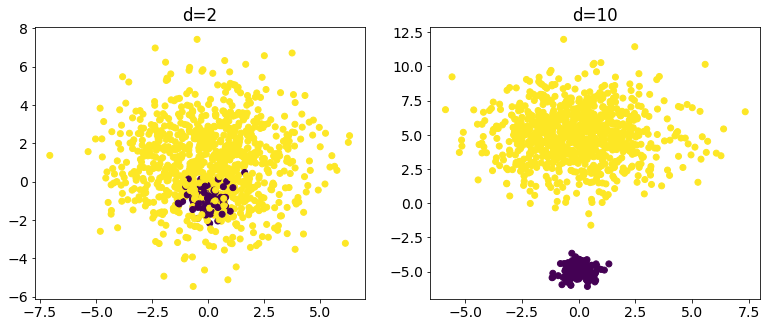

In [ ]:
X2,  y2  = make_data(d=2)
X10, y10 = make_data(d=10)

# Plotting
plt.rcParams["figure.figsize"] = (13,5)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(X2[:,0], X2[:,1], c=y2)
ax2.scatter(X10[:,0], X10[:,1], c=y10)

ax1.set_title('d=2')
ax2.set_title('d=10');




**Where would you think the SVM hyperplane will lie?**   
We assume that the hyperplane will lie in the middle of the left plot and between the clusters in the right plot.

### 2.2 Drawing the seperation hyperplane on top of the scatter.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

plt.rcParams["figure.figsize"] = (13,5)

def plot_hyperplane(imbalance):
    """ Generates the data and plots the hyperplanes """

    d = [2, 10]
    X2,  y2  = make_data(d=d[0], imbalance=imbalance)
    X10, y10 = make_data(d=d[1], imbalance=imbalance)

    i = 0
    for X, y in [(X2, y2), (X10, y10)]:
        #clf  = make_pipeline(StandardScaler(), LinearSVC())
        clf = LinearSVC()
        clf.fit(X, y)
        ac = accuracy_score(y, clf.predict(X))
        ba = balanced_accuracy_score(y, clf.predict(X))

        # Plotting the data
        plt.subplot(1, 2, i + 1)
        plt.scatter(X[:,0], X[:,1], c=y)

        # Getting the hyperplane 
        w = clf.coef_[0] 
        a = -w[0] / w[1] 
        xx = np.linspace(-10, 10)
        yy = a * xx - (clf.intercept_[0]) / w[1]

        # Defining the margins
        margin = 1 / np.sqrt(np.sum(clf.coef_**2))
        yy_down = yy - np.sqrt(1 + a**2) * margin
        yy_up = yy + np.sqrt(1 + a**2) * margin

        # Plotting the margins
        plt.plot(xx, yy, "k-")
        plt.plot(xx, yy_down, "k--")
        plt.plot(xx, yy_up, "k--")

        plt.title(f'd={d[i]} accuracy={np.round(ac, 3)} balance accuracy={np.round(ba, 3)}')

        i += 1

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


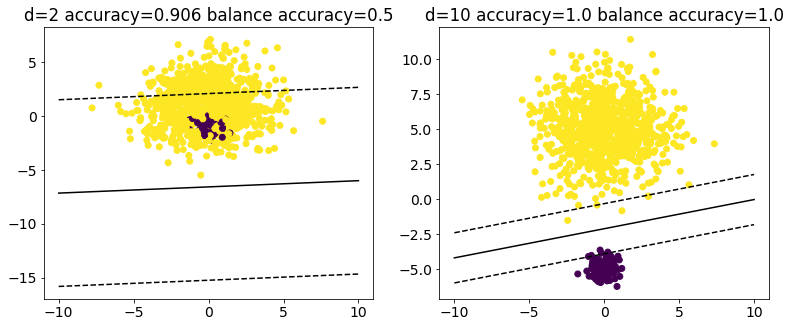

In [ ]:
# For imbalance of 0.1
plot_hyperplane(0.1)

### 2.3 Repeating the experiment with balanced class_weight. 

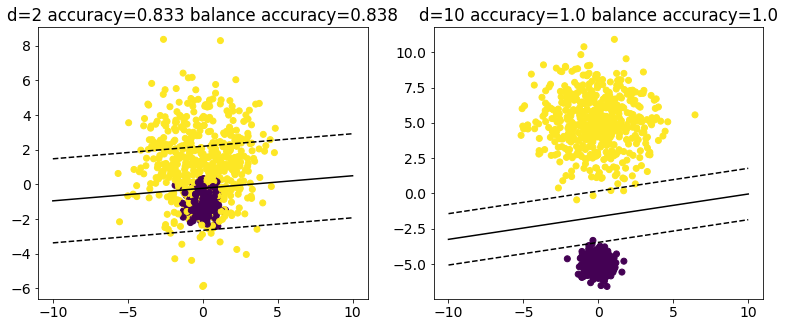

In [ ]:
plot_hyperplane(0.5)

**Add explanation what was the problem and how changing class weight solved it.**   
In general, classifying models are designed to output the simplest hypothesis that best fits the data. For imbalanced data, the simplest hypothesis is usually the one that classifies all instances as negative (in our case - 1). In particular, the soft margins of the SVM algorithm are designed to make the model more immune to noise and therefore ignore the undersampled data.

## 3. SVM hyperparameter search
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process. 

To do this you can use the handy `cross_val_score` function.

Use the cancer dataset for this question


## Answer #

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


# Standardizing 
scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.30) 

# Defining parameter range 
param_grid = {'multi_class':['ovr', 'crammer_singer'],
              'loss':['hinge', 'squared_hinge'],
              'C': np.logspace(-4,4,10)} 

# Training the GridCV model
grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3,n_jobs=-1) 
grid.fit(X_train, y_train) 
print('The best SVM parameters were found to be:', grid.best_params_)

# Comparing SVM with best parameters to the naive SVM model
print('Mean score of naive SVM:\t',np.mean(cross_val_score(LinearSVC(), X_test, y_test, cv=10)))
print('Mean score of best  SVM:\t',np.mean(cross_val_score(LinearSVC(C=0.04641588, loss='squared_hinge', multi_class='ovr') , X_test, y_test, cv=10)))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
The best SVM parameters were found to be: {'C': 0.046415888336127774, 'loss': 'hinge', 'multi_class': 'crammer_singer'}
Mean score of naive SVM:	 0.9709150326797384
Mean score of best  SVM:	 0.9882352941176471


We can see a minor improvement in the performance of the optimized SVM.

## 4. Classifying Checkerboard with SVM (20)
In this exercise you will try to choose a kernel for classifying a checkerboard labeled data. 

* Use the `checkboard` function below to generate
your training set (1000 or 2000 samples) and a testing set (as much as you like). As you can see the function generates samples in 2D and label them according to a 3 × 3 checkerboard (obviously linear separation will not do the job here). Python’s scatter in the might come in handy.

* Use SVM to find a good linear separation in high dimensional feature space using the polynomial or the Gaussian (RBF) kernel.    You should evaluate for both models the best parameters to use. Explain how do you evalute each model?
   - For polynomial kernel, estimate which degree to use
   - For RBF, estimate which standard deviation to use
   - For both models, also choose which regularization parameter is best to use
 
* For the best model of each kernel, plot a scatter plot of the training patterns (colored by label) and mark the support vectors as well. Which model would you choose to use in this case?

* In addition, if you are curious, you can try and think of a way to plot the separating hyper-surface (curve in this case), the margin, and the testing set (to check which points are misclassified).

In [ ]:
import numpy as np
def checkerboard(n):
    """
    CHECKERBOARD Sample points from a 3x3 checkerboard in 2D
    """
    X = np.random.rand(n,2); # samples dimension N = 2
    l = np.mod(np.ceil(X*3), 2);
    y0 = np.logical_xor(l[:,0], l[:,1])
    y = y0*2-1 # {-1,+1}
    return X, y

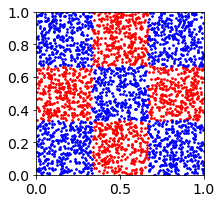

In [ ]:
# Usage sample
import matplotlib.pyplot as plt
X, y = checkerboard(3000)
plt.figure(figsize=(3,3))
plt.scatter(X[y==1,0], X[y==1,1], c='r', s=3)
plt.scatter(X[y==-1,0], X[y==-1,1], c='b', s=3)
plt.xlim([0,1])
plt.ylim([0,1]);

### Using the checkboard function below to generate your training set (2000 samples) and a testing set (of 500 samples)

In [ ]:
X_train, y_train = checkerboard(2000)
X_test, y_test = checkerboard(500)

print(X_test.shape)

# Standaring X
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test
    }

(500, 2)


### Using SVM to find a good linear separation in high dimensional feature space using the polynomial or the Gaussian (RBF) kernel.

Defining the plotting function

In [ ]:
def plot_checkers(clf, data):
    """ Plots the checkerboard's predcitions """

    # Enlarging font and figure size
    plt.rcParams["figure.figsize"] = (13, 6)
    plt.rcParams.update({'font.size': 14})

    # Unpacking the data
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']

    # Fitting the optimal model
    clf.fit(X_train, y_train)
    ypreds = clf.predict(X_train)

    # Finding accuracy
    ac = accuracy_score(y_test, clf.predict(X_test))

    # Getting the support vectors
    sp_indeces = clf.support_
    sp = X_train[sp_indeces]

    # Plotting the data
    plt.subplot(1, 2, 1)
    plt.scatter(X_train[:,0], X_train[:,1], c=ypreds)
    plt.scatter(sp[:,0], sp[:,1], s=100, linewidth=1, facecolors="none", edgecolors="c")
    plt.title(f'Support vectors. Test accuracy = {ac}')

    plt.subplot(1, 2, 2)
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
    plt.scatter(X_train[:,0], X_train[:,1], c=ypreds, alpha=0.5)
    plt.title(f'Prediction errors (in brown)')


Defining a function which finds the best hyperparamaters using GridSearchCV and plots validation curves for the parameters values

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


def test_param(kernel, param_grid, data, log = False):
    """ Runs GridSearchCV and prints the best parameters """

    # Unpacking the data
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']

    grid = GridSearchCV(SVC(kernel=kernel), param_grid, refit = True, verbose = 3,n_jobs=-1) 
    grid.fit(X_train, y_train) 
    grid_preds = grid.predict(X_test)
    print(f'Grid SVM accuracy: {accuracy_score(y_test, grid_preds)} with the prameter {grid.best_params_}')
    plot_validation_curve(SVC(kernel=kernel), X_test, y_test, param_grid, log=log)

    return grid


#### Estimating hyperparameters for the **polynomial kernel**

Etimatation of the degree and gularization parameter

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Grid SVM accuracy: 0.682 with the prameter {'C': 0.01778279410038923, 'degree': 2.0}


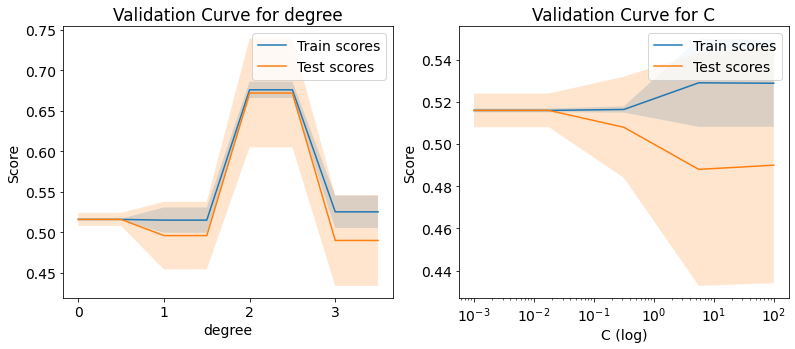

In [ ]:
param_range = {'degree': np.arange(0, 4, 0.5),
               'C': np.logspace(-3, 2, 5)}
test_param('poly', param_range, data);

Plotting the best model

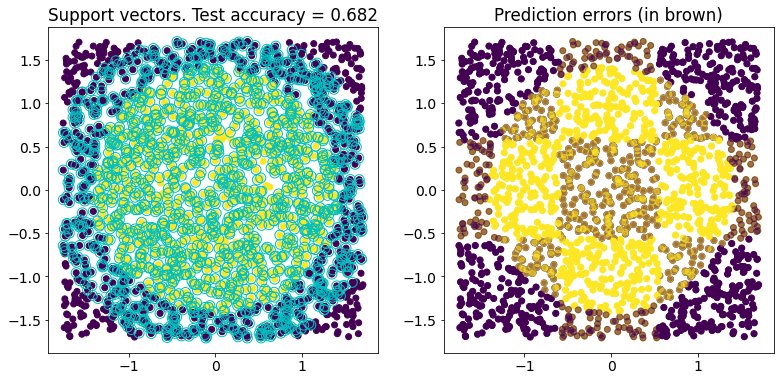

In [ ]:
plot_checkers(SVC(kernel='poly', degree=2.0, C=0.01778), data)

#### Estimating hyperparameters for the **Gaussian kernel**

Estimations of the standard deviation and the gularization parameter 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Grid SVM accuracy: 0.984 with the prameter {'C': 100.0, 'gamma': 1.0}


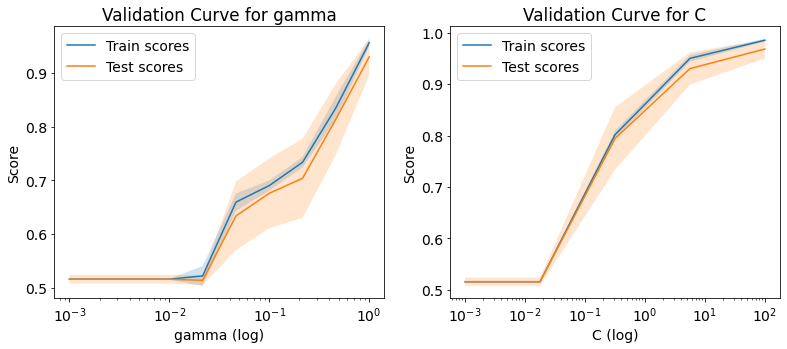

In [ ]:
test_param('rbf', {'gamma':  np.logspace(-3, 0, 10), 'C': np.logspace(-3, 2, 5)}, data, log=True);

Plotting the best model

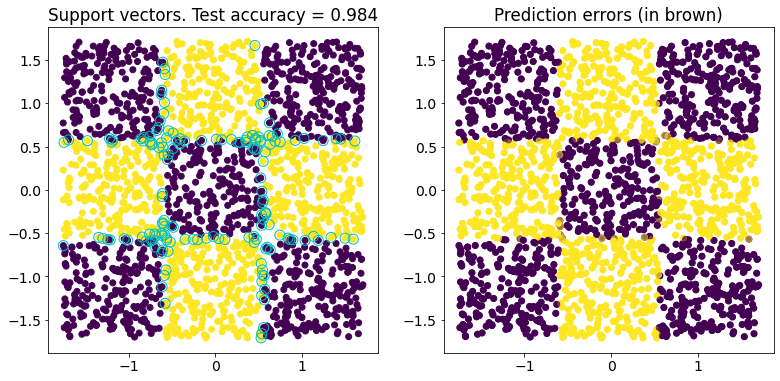

In [ ]:
plot_checkers(SVC(kernel='rbf', gamma=1.0, C=100), data)

**Which model would you choose to use in this case?**   
We would prefer the Gaussian, RBF, model, which separates the data with higher success.

## Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

